**NAMA  : DESI DWI PURWASIH**

**NIM        : 1304212095**

# **Chronic Kidney Disease**




Dataset yang digunakan diambil dari Kaggle dengan judul “Chronic Kidney Disease Dataset”, yang berisi 400 data rekam medis pasien dan terdiri dari 26 atribut. Dataset ini dipilih karena memuat berbagai fitur klinis yang relevan untuk membangun model prediktif dalam mendiagnosis penyakit ginjal kronis (CKD).

Meskipun ukuran dataset ini tergolong kecil, proyek ini mengintegrasikan Apache Spark melalui PySpark sebagai alat pemrosesan data skala besar. Pendekatan ini digunakan untuk mensimulasikan penerapan teknologi Big Data terhadap data klinis yang berpotensi meningkat dalam volume dan kompleksitas di dunia nyata.

In [ ]:
!pip install pyspark
!apt install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark


In [ ]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

findspark.init()

In [ ]:
# Import Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit


In [ ]:
spark = SparkSession.builder.appName("CKD_Classification").getOrCreate()


In [ ]:
# Load data
df = spark.read.csv("kidney_disease.csv", header=True, inferSchema=True)
df.show()

+---+----+-----+-----+----+----+--------+--------+----------+----------+-----+-----+----+-----+----+----+----+-----+----+---+---+---+-----+---+---+--------------+
| id| age|   bp|   sg|  al|  su|     rbc|      pc|       pcc|        ba|  bgr|   bu|  sc|  sod| pot|hemo| pcv|   wc|  rc|htn| dm|cad|appet| pe|ane|classification|
+---+----+-----+-----+----+----+--------+--------+----------+----------+-----+-----+----+-----+----+----+----+-----+----+---+---+---+-----+---+---+--------------+
|  0|48.0| 80.0| 1.02| 1.0| 0.0|    null|  normal|notpresent|notpresent|121.0| 36.0| 1.2| null|null|15.4|  44| 7800| 5.2|yes|yes| no| good| no| no|           ckd|
|  1| 7.0| 50.0| 1.02| 4.0| 0.0|    null|  normal|notpresent|notpresent| null| 18.0| 0.8| null|null|11.3|  38| 6000|null| no| no| no| good| no| no|           ckd|
|  2|62.0| 80.0| 1.01| 2.0| 3.0|  normal|  normal|notpresent|notpresent|423.0| 53.0| 1.8| null|null| 9.6|  31| 7500|null| no|yes| no| poor| no|yes|           ckd|
|  3|48.0| 70.0|1.005|

In [ ]:
df.describe().show()

+-------+------------------+-----------------+-----------------+--------------------+------------------+-------------------+--------+--------+----------+----------+-----------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+----+----+----+-----+----+----+--------------+
|summary|                id|              age|               bp|                  sg|                al|                 su|     rbc|      pc|       pcc|        ba|              bgr|                bu|                sc|               sod|              pot|              hemo|              pcv|                wc|                rc| htn|  dm| cad|appet|  pe| ane|classification|
+-------+------------------+-----------------+-----------------+--------------------+------------------+-------------------+--------+--------+----------+----------+-----------------+------------------+------------------+------------------+---

In [ ]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- bp: double (nullable = true)
 |-- sg: double (nullable = true)
 |-- al: double (nullable = true)
 |-- su: double (nullable = true)
 |-- rbc: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- pcc: string (nullable = true)
 |-- ba: string (nullable = true)
 |-- bgr: double (nullable = true)
 |-- bu: double (nullable = true)
 |-- sc: double (nullable = true)
 |-- sod: double (nullable = true)
 |-- pot: double (nullable = true)
 |-- hemo: double (nullable = true)
 |-- pcv: string (nullable = true)
 |-- wc: string (nullable = true)
 |-- rc: string (nullable = true)
 |-- htn: string (nullable = true)
 |-- dm: string (nullable = true)
 |-- cad: string (nullable = true)
 |-- appet: string (nullable = true)
 |-- pe: string (nullable = true)
 |-- ane: string (nullable = true)
 |-- classification: string (nullable = true)



In [ ]:
# Drop kolom id
df = df.drop("id")

In [ ]:
from pyspark.sql.functions import when, col

# Bersihkan kolom dengan nilai tidak valid
for col_name in ['dm', 'cad']:
    df = df.withColumn(col_name, when(col(col_name).like("?\t?"), None).otherwise(col(col_name)))


In [ ]:
# Convert kolom numerik dari string ke float
for col_name in ['pcv', 'wc', 'rc']:
    df = df.withColumn(col_name, col(col_name).cast("float"))

**Cleaning**

In [ ]:
from pyspark.sql.functions import col, when, count, isnan

# Cek jumlah missing value per kolom
df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns]).show()

+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
|age| bp| sg| al| su|rbc| pc|pcc| ba|bgr| bu| sc|sod|pot|hemo|pcv| wc| rc|htn| dm|cad|appet| pe|ane|classification|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+
|  9| 12| 47| 46| 49|152| 65|  4|  4| 44| 19| 17| 87| 88|  52| 71|106|131|  2|  2|  2|    1|  1|  1|             0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+-----+---+---+--------------+



In [ ]:
# Ganti label ckd/notckd ke angka
df = df.withColumnRenamed("classification", "label")

In [ ]:
# Drop missing values
df_clean = df.dropna()

In [ ]:
# Kolom kategorikal
categorical_cols = [col_name for col_name in df_clean.columns if df_clean.select(col_name).dtypes[0][1] == 'string' and col_name != "label"]

# StringIndexer untuk kategorikal
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in categorical_cols]

# Encode label
label_indexer = StringIndexer(inputCol="label", outputCol="label_index")

# Fitur akhir (gabungkan semua kolom numerik dan indeks)
indexed_features = [col + "_index" for col in categorical_cols]
numeric_features = [col for col, dtype in df_clean.dtypes if dtype in ['double', 'int'] and col != "id"]
final_features = numeric_features + indexed_features

assembler = VectorAssembler(inputCols=final_features, outputCol="features")


**Model random forest**

In [ ]:
rf = RandomForestClassifier(labelCol="label_index", featuresCol="features")

pipeline = Pipeline(stages=indexers + [label_indexer, assembler, rf])

**Training dan Evaluasi**

In [ ]:
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)

paramGrid = ParamGridBuilder()\
    .addGrid(rf.numTrees, [20, 50])\
    .addGrid(rf.maxDepth, [5, 10])\
    .build()

tvs = TrainValidationSplit(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=MulticlassClassificationEvaluator(labelCol="label_index", metricName="accuracy"),
    trainRatio=0.8
)


**Fit Model dan prediksi**

In [ ]:
model = tvs.fit(train_data)
predictions = model.transform(test_data)

# Evaluasi akurasi
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.4f}")

# Evaluasi AUC
binary_eval = BinaryClassificationEvaluator(labelCol="label_index")
auc = binary_eval.evaluate(predictions)
print(f"AUC: {auc:.4f}")


Accuracy: 1.0000
AUC: 1.0000


In [ ]:
!pip install matplotlib scikit-learn

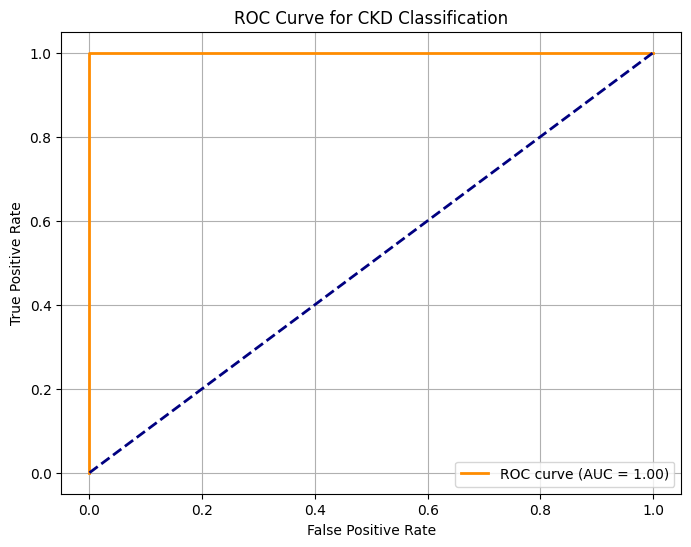

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

results = predictions.select("probability", "label_index").collect()
y_score = [row['probability'][1] for row in results]  # Probabilitas untuk kelas 1
y_true = [row['label_index'] for row in results]      # Label asli

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CKD Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


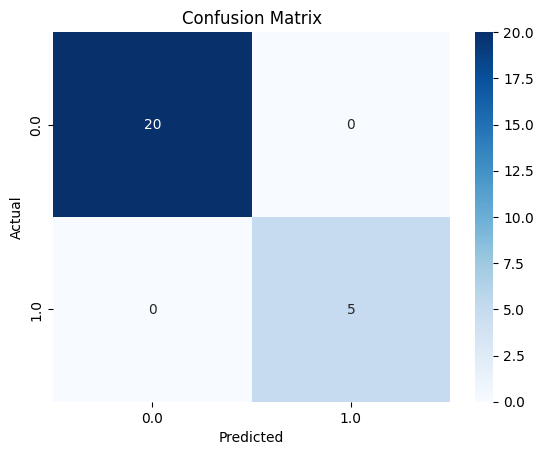

In [ ]:
# Konversi ke Pandas untuk visualisasi
pd_pred = predictions.select("label_index", "prediction").toPandas()

conf_matrix = pd.crosstab(pd_pred["label_index"], pd_pred["prediction"], rownames=["Actual"], colnames=["Predicted"])

import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
